<a target="_blank" href="https://colab.research.google.com/github/justramle/Emotion-Recognition-with-Convolutional-Neural-network/blob/main/emotion_classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Note:
To run this dataset onn colab: 
- Upload a zip file (images.zip) of a folder directly on the Colab notebook
- !unzip images.zip

# Train a deep learning model with Four‐layer ConvNet and Two-NN on facial emotion recognition with pytorch

### Dataset: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

- Consist of 48x48 pixels gray scales images of faces belong to 7 class
- size: 36k images
- 80% of images are insided the train folder and 20% are insided the validation folder

## References:

- https://cs231n.github.io/convolutional-networks/
- Paper 1: <br>
https://arxiv.org/pdf/1704.06756.pdf
- Source Code of CNN architect with tensorflow 1: <br>
https://github.com/rishabhjainps/Facial-Expression-Recognition/blob/master/cnn_major.py

- Paper 2: <br>
https://www.nature.com/articles/s41598-022-11173-0
- Source Code of CNN architect with tensorflow 2: <br>
https://github.com/Tanoy004/Emotion-recognition-through-CNN/blob/main/emotion_recognition.py


## Loading, splitting, processing and exploring the dataset

In [2]:
import torch
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.1.2


### Loading the dataset

In [48]:
import os
import cv2

train_data_dir = 'images/train/'
validation_data_dir = 'images/validation/'

# debug
print(os.listdir(train_data_dir))

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


### Read all images in array

In [49]:
# Function to load the image
def load_image(directory):
    images_path = []
    labels = []
    # access into each label folder and image inside that label
    for images_class in os.listdir(directory):
        for image_file in os.listdir(os.path.join(directory, images_class)):
            image_path = os.path.join(directory, images_class, image_file)
            # use openCV to open and read the image in grayscale: convert image into 2D Numpy Array: 
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)    
            images_path.append(image)
            labels.append(images_class)
    return images_path, labels

### exploring the dataset

In [50]:
import pandas as pd

train = pd.DataFrame()
train['image'], train['label'] = load_image(train_data_dir)      # call the load_image function on train folder
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train

,image,label
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",fear
1,"[[127, 142, 126, 117, 123, 92, 41, 95, 143, 15...",neutral
2,"[[69, 66, 74, 61, 70, 64, 56, 65, 66, 79, 101,...",sad
3,"[[239, 241, 238, 248, 162, 58, 54, 46, 43, 26,...",neutral
4,"[[11, 3, 10, 14, 4, 21, 15, 25, 34, 46, 64, 83...",sad
...,...,...
28816,"[[179, 122, 108, 141, 167, 153, 150, 126, 128,...",angry
28817,"[[21, 39, 47, 36, 50, 63, 67, 80, 102, 114, 11...",happy
28818,"[[164, 158, 150, 148, 136, 50, 42, 40, 47, 45,...",neutral
28819,"[[239, 240, 238, 237, 238, 235, 233, 182, 192,...",happy


### Visualize a few sample images from training set

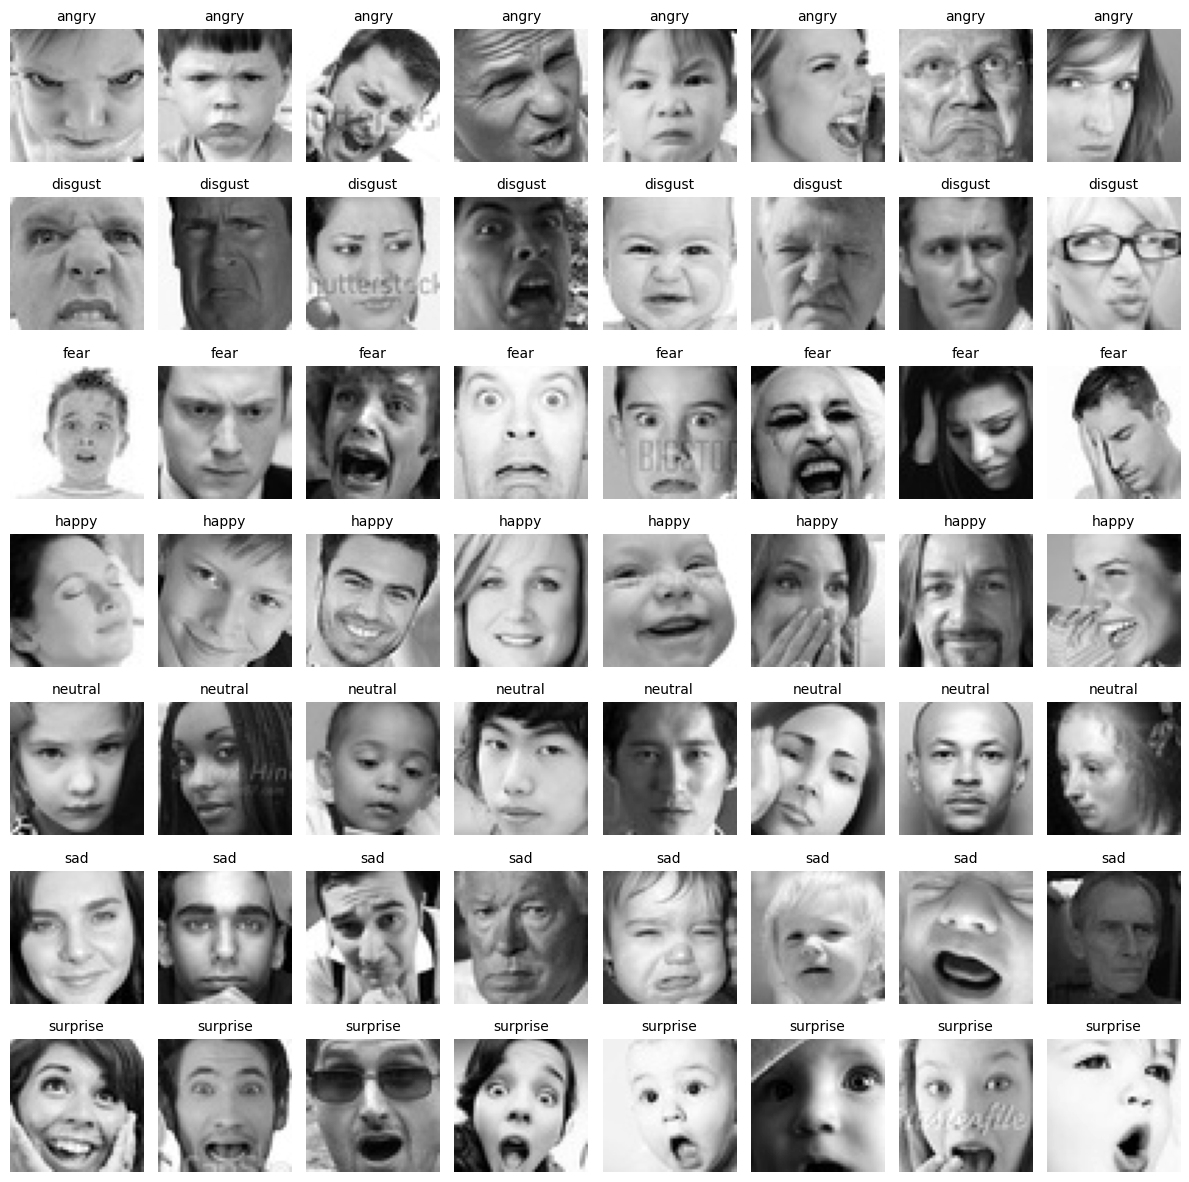

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(images, labels, num_samples):
    # Get unique labels and initialize the plot counter
    class_names = np.unique(labels)
    plot_count = 1
    
    # Determine the total number of plot rows needed
    num_classes = len(class_names)
    fig = plt.figure(figsize=(12, 12))
    
    for class_name in class_names:
        # Find indices of images belonging to the current class
        class_indices = np.where(labels == class_name)[0][:num_samples]
        for idx in class_indices:
            # Create a subplot for each sample image
            ax = fig.add_subplot(num_classes, num_samples, plot_count)
            ax.imshow(images[idx], cmap='gray')
            ax.axis('off')  # Hide axes ticks
            ax.set_title(class_name, fontsize=10)
            plot_count += 1

    plt.tight_layout()
    plt.show()

# function call
plot_sample_images(train['image'], train['label'], num_samples=8)


### Plotting the training set distribution

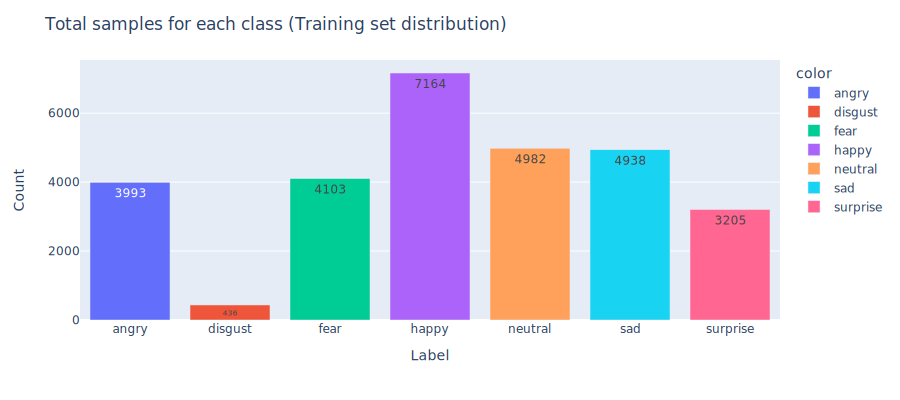

In [52]:
import plotly.express as px
import plotly.io as pio

# comment the renderers if using on colab
pio.renderers

# Calculate the count of images for each class in the training set
train_class_counts = {class_name: np.sum(train['label'] == class_name) for class_name in np.unique(train['label'])}

# bar chart using Plotly Express for training set only
fig = px.bar(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), color=list(train_class_counts.keys()))

# Customize the layout of the chart
fig.update_layout(
    title="Total samples for each class (Training set distribution)",
    xaxis_title="Label",
    yaxis_title="Count",
    width=900,
    height=400
)
fig.update_traces(texttemplate='%{y}', textposition='inside')  # Display count labels on the bars
fig.show(renderer="svg")

### Processing images and split dataset

- Process help to prevent overfitting and improve performance include: 
    - do image augmentation on trainset: randomly transform or change color of the original image, to increase the diversity
    - convert to tensor
    - normalize dataset

In [6]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# image augmentation and transform on gray scale of black and white image

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # channel 1 for black and white: 3 for RGB
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(20),  # Randomly rotate the image by 20 degrees
    transforms.ToTensor(),  # Convert pixe imagel [0-255] to tensor: range [0, 1], 0: black and 1: white)
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the tensor so values centered around 0, with a range [0, 1] to [-1, 1]
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

- Splitting include:
    - the test set: the data that training model never seen before. This will use to evaluate the final perfomance
    - splitting 50% the data from validation folder
    - 80% for training, 10% for validation, 10% for testing
    - So there are about 28,821 training images, 3,533 validation images, and 3,533 images for testing.

- After splitting, load the dataset to loader with mini batch size 128 
    - shuffle training set but not validation set

In [16]:
from torch.utils.data.dataset import random_split

# put appy transform on images 
train_set = ImageFolder(root=train_data_dir, transform=train_transforms)
val_set = ImageFolder(root=validation_data_dir, transform=val_transforms)

# split proportion: 10% val and 10% on test
val_size = int(0.5 * len(val_set))  
test_size = len(val_set) - val_size

val_dataset, test_dataset = random_split(val_set, [val_size, test_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)    
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)    


print(f"Number of training samples: {len(train_set)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Check the shape of the first training image [channel, width, height]
train_x, train_y = train_set[0]
print(f"Shape of training images : {train_x.shape}")
print(f"Shape of training images : {train_y}")

class_name = train_set.classes[train_y]
print(f"Class name of training image: {class_name}")


for images, labels in train_loader:
    print(f"Shape of 1st batch training images (after transformations): {images.shape}")
    break  #first batch: 128


Number of training samples: 28821
Number of validation samples: 3533
Number of test samples: 3533
Shape of training images : torch.Size([1, 48, 48])
Shape of training images : 0
Class name of training image: angry
Shape of 1st batch training images (after transformations): torch.Size([128, 1, 48, 48])


## CNN model
### Bulding Deep Learning model with 4-layer of convolutional neural network and 2 fully connected layer

In [17]:
# mport pytorch library and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
from torch.optim import Adam
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, BatchNorm2d, BatchNorm1d, Dropout

### Architecture of Deep CNN model
- 4 convolutional layes to extract features from images with 64 3x3 filters, 128 5x5 filters, 512 3x3 filters, 512 3x3 filters 
    - Each convolutional layer: stride 1, batch normalization, dropout rate 0.5, max-pooling and ReLU
- flattening step
- 2 fully connected dense layers to classify those features into respective label
    - 256 neuron of first hidden layers and 512 neuron of second hidden layers
    - batch norm, dropout, ReLu on each layer
- Final output: softmax for convert output to probability (sum the result of softmax should be equal to 1) <br> <br>
- For objective function in supervise learning task: goal is to minimize this function (distance between predict and actual)
    - Loss function: using cross entropy because this is classification problems
    - Optimization: Using Adam with learning rate at 0.01, weight regulation at 1e-7
    - backward() propergate to cal the gradient base on the chain rule

In [36]:
class convnet(nn.Module):
    # constructor initialize instances of class
    def __init__(self, num_classes):
        super(convnet, self).__init__()         # Call the init method of nn.Module

        # defining 2D convolutional layers by Squential for cleaner look
        self.cnn_layers = Sequential(
            # stride=1 paddind = 0 by default
            # first block: 
            Conv2d(1, 64, kernel_size = 3, stride=1, padding = 1),  # dot product of input and kernel to complete 1 pixel at a time: stride
            BatchNorm2d(64),                                        # improves the performance and stability of NNs with unit
            ReLU(),                                                 # non linear func to squash linear combination into 0 and 1
            # Dropout(p=0.25),                                         # reduces overfitting/prevent not relying on one node in the layer too much
            # MaxPool2d(kernel_size=2 , stride=2),                    # reduce dimension but still obtain important data

            # second block
            Conv2d(64, 128, kernel_size = 3, stride=1, padding = 1),
            BatchNorm2d(128), 
            ReLU(),
            Dropout(p=0.25),
            MaxPool2d(kernel_size=2 , stride=2),
            
            # third block
            Conv2d(128, 512, kernel_size = 3, stride=1, padding = 1),
            BatchNorm2d(512), 
            ReLU(),                                                
            Dropout(p=0.25),
            MaxPool2d(kernel_size=2 , stride=2),

            # fourth block
            Conv2d(512, 512, kernel_size = 3, stride=1, padding = 1),
            BatchNorm2d(512), 
            ReLU(),
            Dropout(p=0.25),
            MaxPool2d(kernel_size=2 , stride=2),
        )

        # definind 2 fully connected layer (multi layers nn)
        self.linear_layers = Sequential(
            # 256 neuron of first hidden layers and 512 neuron of second hidden layers

            # first fully connected layer  (input to hidden1)
            Linear(18432, 256),       # input size of flatten layer: 512 * 2 * 2 with 256 hidden node in first hidden layer
            BatchNorm1d(256),
            ReLU(),
            Dropout(p=0.5),

            # second fully connected layer  (hidden to hidden 2)
            Linear(256, 512),              # 512 hidden node in second hidden layer 
            BatchNorm1d(512),
            ReLU(),
            Dropout(p=0.25),

            # hidden 2 to output: 7 category
            Linear(512, num_classes)
        )
    
    def forward(self, x):
        # forward pass through cnn and linear layers
        z1 = self.cnn_layers(x)  

        z1 = z1.view(z1.size(0), -1)  # Flatten the output of conv layers       
        # output flatten of convo layer is input of fully connected layer
        z2 = self.linear_layers(z1) 
        
        # return F.softmax(z2, dim = 1) 
        return z2



### debug to check the size of output of flatten layer before feed in FC layers

In [37]:
model = convnet(num_classes=7)  # instantiate the instance of class 

# Create input with the size of input images (batch_size, channels, height, width)
check_input = torch.randn(1, 1, 48, 48)

check_input = model.cnn_layers(check_input)
# Print the resulting size
print(check_input.size())

torch.Size([1, 512, 6, 6])


### define the opmizier and loss function for model

In [38]:
# Instantiate the model
num_classes = 7
model = convnet(num_classes)

# defining the optimizer: Adam with regulation to prevent overfitting
optimizer = Adam(model.parameters(), lr = 0.001, weight_decay=1e-7)     
# defining the loss function
criterion = CrossEntropyLoss()
print(model)


convnet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.25, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [39]:
# no gpu
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)
model = model.to(device)

mps


### Training and Evaluate the model on both validation 

In [40]:
#train process
def fit(epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):

        # --------Training loss--------
        tr_loss = 0
        # set model in training mode
        model.train()
        for inputs, labels in train_loader:
            # load dataset to device
            inputs, labels = inputs.to(device), labels.to(device)

            # clear the gradient of model parameters
            optimizer.zero_grad()

            # Forward pass: prediction for training and validation set from the input
            train_output = model(inputs)                            # output from predict on training set
            train_loss = criterion(train_output, labels)            # calculate the loss between output and ground truth with cross entropy

            # Backward pass and optimize: to updated the weight of all model parameters to improve the loss
            train_loss.backward()                                   # backpropagate
            optimizer.step()                                        # gradient decent to update paramter
            tr_loss += train_loss.item()                            # extract and keep track loss each epochs: .item(): is single-element tensor convert to float format

        avg_train_loss = tr_loss/ len(train_loader)                 # divide accumulated loss by the number of batches 
        train_losses.append(avg_train_loss)


        # --------Validation loss--------
        validate_loss = 0
        model.eval()
        with torch.no_grad():                                       # no gradient on validation
            for inputs, labels in val_loader:
                # load dataset to device
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass on validation. No backward on validation
                val_output = model(inputs)                                 
                val_loss = criterion(val_output, labels)            
                validate_loss += val_loss.item()                            # keep track of loss each epochs
            
            avg_val_loss = validate_loss/len(val_loader)  

            # Check if this is the best model so far
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict() # save the best model state
                torch.save(model.state_dict(), 'best_model_state.pth')
            val_losses.append(avg_val_loss)                                 # store loss value

        # if epoch % 2 == 0:
        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses, best_model_state

### train the model with 50 epochs and store the training and validation losses

In [41]:
num_epochs = 50
train_losses, val_losses, best_model_state = fit(num_epochs)

Epoch 1/50 | Train Loss: 1.6024 | Val Loss: 1.5115
Epoch 2/50 | Train Loss: 1.3468 | Val Loss: 1.3358
Epoch 3/50 | Train Loss: 1.2531 | Val Loss: 1.2338
Epoch 4/50 | Train Loss: 1.2025 | Val Loss: 1.2003
Epoch 5/50 | Train Loss: 1.1661 | Val Loss: 1.1889
Epoch 6/50 | Train Loss: 1.1349 | Val Loss: 1.1660
Epoch 7/50 | Train Loss: 1.1054 | Val Loss: 1.1196
Epoch 8/50 | Train Loss: 1.0833 | Val Loss: 1.1084
Epoch 9/50 | Train Loss: 1.0662 | Val Loss: 1.1298
Epoch 10/50 | Train Loss: 1.0481 | Val Loss: 1.1669
Epoch 11/50 | Train Loss: 1.0297 | Val Loss: 1.0547
Epoch 12/50 | Train Loss: 1.0076 | Val Loss: 1.0817
Epoch 13/50 | Train Loss: 0.9982 | Val Loss: 1.0386
Epoch 14/50 | Train Loss: 0.9791 | Val Loss: 1.0124
Epoch 15/50 | Train Loss: 0.9679 | Val Loss: 1.0336
Epoch 16/50 | Train Loss: 0.9455 | Val Loss: 1.0584
Epoch 17/50 | Train Loss: 0.9270 | Val Loss: 1.1152
Epoch 18/50 | Train Loss: 0.9191 | Val Loss: 1.0266
Epoch 19/50 | Train Loss: 0.9006 | Val Loss: 1.0018
Epoch 20/50 | Train L

In [42]:
import plotly.graph_objects as graph
# pio.renderers

fig = graph.Figure()

# the training loss 
fig.add_trace(graph.Scatter(y=train_losses, mode='lines', name='Training Loss'))
# the validation loss 
fig.add_trace(graph.Scatter(y=val_losses, mode='lines', name='Validation Loss'))
# Update the layout with titles and axis labels
fig.update_layout(title='Training and Validation Loss over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Loss',
                  width=900,
                  height=400)

# fig.add_trace(go.Scatter(y=train_losses, fill='tozeroy', mode='lines', name='Training Loss'))  # Fill to x-axis
# fig.add_trace(go.Scatter(y=val_losses, fill='tozeroy', mode='lines', name='Validation Loss'))

fig.show()

### check the accuracy of the model on the training and validation set:

In [43]:
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = 0
    total_samples = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # No track gradients
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_pred = torch.argmax(outputs, dim=1)               # Use argmax to get predictions: highest prob

            # accuracy metric as the number of correctly predicted results / total numbe of samples
            predictions += torch.sum(y_pred == labels).item()
            total_samples += labels.size(0)                        # length of tensor at first dimension

            # store for confusion matrix from scikit-learn in numpy form
            pred_labels.extend(y_pred.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    total_acc = predictions / total_samples
    # print(f'Accuracy: {total_acc:.2f}')
    
    return total_acc, true_labels, pred_labels

- prediction is pass the input data through the model
- true label is provide in DataLoader

In [44]:
train_accuracy, true_labels, pred_labels = calculate_accuracy(model, train_loader)
print(f'Train Accuracy: {train_accuracy:.4f}')

Train Accuracy: 0.8000


In [45]:
# model.load_state_dict(best_model_state)

val_accuracy, true_labels, pred_labels = calculate_accuracy(model, val_loader)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.6595


In [53]:
import numpy as np
test_accuracy, true_labels, pred_labels = calculate_accuracy(model, test_loader)
print(f'Test final perfomance Accuracy: {test_accuracy:.4f}')

class_names = np.unique(train['label'])

# Convert numeric labels to string using mapping
true_labels = [class_names[label] for label in true_labels]
pred_labels = [class_names[label] for label in pred_labels]

# Create a DataFrame with both true and predicted labels
pred_y = pd.DataFrame({'true_label': true_labels, 'predicted_label': pred_labels})

# Filter the DataFrame to only include rows where true_label == predicted_label
correct_predictions = pred_y[pred_y['true_label'] == pred_y['predicted_label']]
correct_predictions

Test final perfomance Accuracy: 0.6547


,true_label,predicted_label
0,happy,happy
3,neutral,neutral
6,happy,happy
9,sad,sad
11,angry,angry
...,...,...
3523,surprise,surprise
3525,sad,sad
3527,surprise,surprise
3530,happy,happy


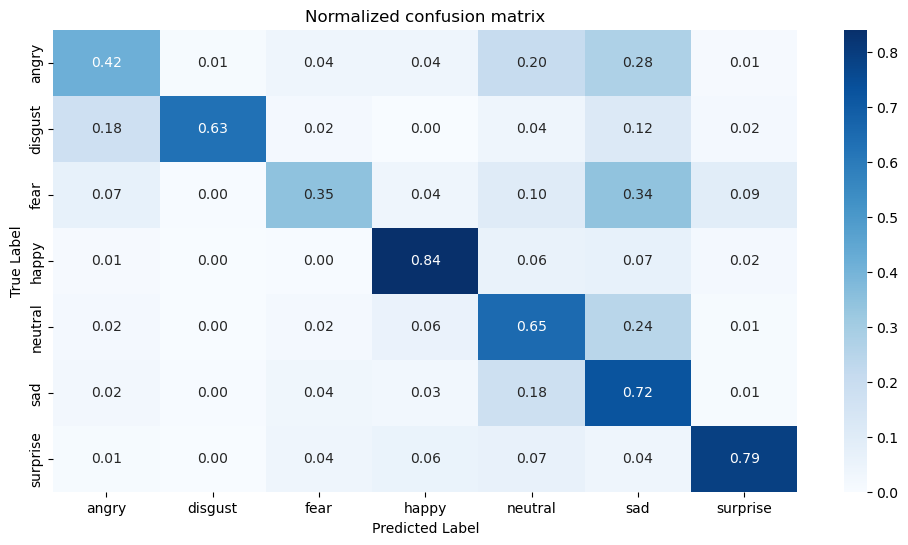

In [54]:
from sklearn.metrics import confusion_matrix


# class_names = np.unique(train['label'])

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with class names
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", fmt=".2f", cbar=True, 
            xticklabels=class_names, yticklabels=class_names)

plt.title("Normalized confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Conclusion: <br>
1. I was facing with overfitting issues to fix that I use a few regulation techniques:

    - L2 weight regualation: 1e-7 (add penalty on magnitude to the loss function)
    - Adjust the dropout rate
    - Adding image augmentation to make train set more diverse
    - shuffle train set
    - Early stop to stop the training before it begin to overfit 
    - Apply batch normalization
    - Checkpointing and fine-tuning based on the best-performing checkpoint at each epoch